In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np, os

In [3]:
DATASET_DIR = "/content/drive/MyDrive/Datasets/Skin Cancer with Categories/Skin cancer ISIC/Train"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 9

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [5]:
all_labels = []
for _, labels in train_ds.unbatch():
    all_labels.append(int(labels.numpy()))

classes = np.unique(all_labels)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=all_labels
)

class_weights = {i: float(w) for i, w in enumerate(class_weights_array)}
print(class_weights)
max_weight = max(class_weights.values())
normalized_class_weights = {c: w / max_weight for c, w in class_weights.items()}
print(normalized_class_weights)

{0: 2.1642512077294684, 1: 0.6443725278676735, 2: 2.585858585858586, 3: 0.5656565656565656, 4: 0.7188126754913758, 5: 0.5381381381381382, 6: 3.4329501915708813, 7: 1.402190923317684, 8: 1.731400966183575}
{0: 0.6304347826086956, 1: 0.18770226537216828, 2: 0.7532467532467533, 3: 0.16477272727272727, 4: 0.20938628158844763, 5: 0.15675675675675677, 6: 1.0, 7: 0.4084507042253521, 8: 0.5043478260869565}


In [6]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_ds = train_ds.map(normalize_img)
val_ds = val_ds.map(normalize_img)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

In [9]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [10]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=normalized_class_weights
)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.1431 - loss: 0.8509 - val_accuracy: 0.1454 - val_loss: 2.1523
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 344ms/step - accuracy: 0.2139 - loss: 0.5923 - val_accuracy: 0.2282 - val_loss: 1.9991
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.2855 - loss: 0.5583 - val_accuracy: 0.3445 - val_loss: 1.9947
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 380ms/step - accuracy: 0.2679 - loss: 0.5274 - val_accuracy: 0.2886 - val_loss: 1.8200
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 348ms/step - accuracy: 0.3358 - loss: 0.4815 - val_accuracy: 0.3557 - val_loss: 1.7266
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 344ms/step - accuracy: 0.3683 - loss: 0.4581 - val_accuracy: 0.2729 - val_loss: 1.7073
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 341ms/step - accuracy: 0.3233 - loss: 0.4372 - val_accuracy: 0.3736 - val_loss: 1.6560
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.3991 - loss: 0.4221 - val_accura

In [11]:
save_path_ft =  "/content/drive/MyDrive/skin-cancer/saved_models/modelo_lesiones.keras"
os.makedirs(os.path.dirname(save_path_ft), exist_ok=True)
model.save(save_path_ft)
print(f" Modelo afinado guardado correctamente en: {save_path_ft}")

 Modelo afinado guardado correctamente en: /content/drive/MyDrive/skin-cancer/saved_models/modelo_lesiones.keras


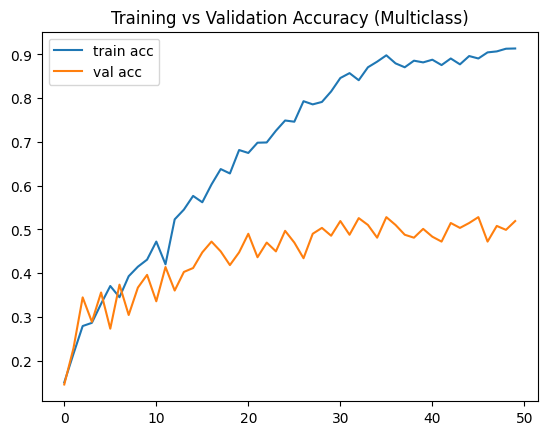

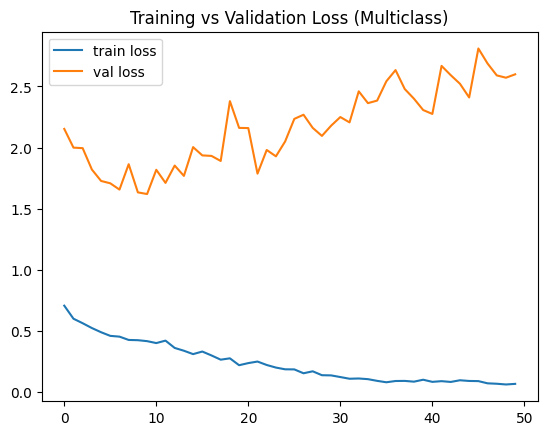

In [12]:
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend(); plt.title("Training vs Validation Accuracy (Multiclass)"); plt.show()

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend(); plt.title("Training vs Validation Loss (Multiclass)"); plt.show()